## BERT tutorial: Classify spam vs no spam emails

In [1]:

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

2023-08-16 18:11:21.773075: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-16 18:11:21.827248: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-16 18:11:21.828456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 18:11:22.902872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Import the dataset (Dataset is taken from kaggle)

In [2]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

<Axes: xlabel='Category'>

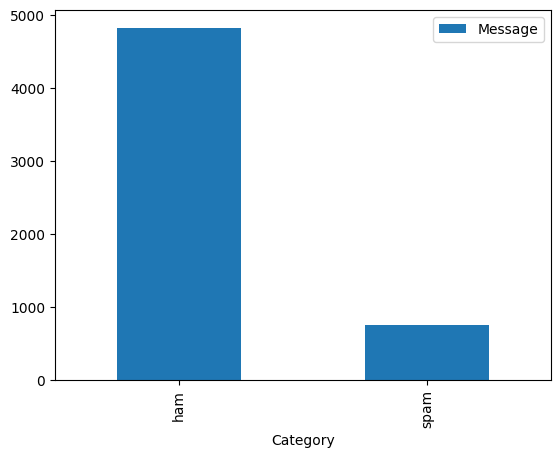

In [3]:
df.groupby('Category').count().plot.bar(ylim=0)

In [5]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [6]:
747/4825

0.15481865284974095

**15% spam emails, 85% ham emails: This indicates class imbalance**

In [7]:
df_spam = df[df['Category'] == 'spam']
df_spam.sample(5)

,Category,Message
1172,spam,Got what it takes 2 take part in the WRC Rally...
3056,spam,EASTENDERS TV Quiz. What FLOWER does DOT compa...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
4991,spam,Phony £350 award - Todays Voda numbers ending ...
367,spam,"Update_Now - Xmas Offer! Latest Motorola, Sony..."


In [8]:
df_ham = df[df['Category'] == 'ham']
df_ham.sample(5)

,Category,Message
4692,ham,Surly ill give it to you:-) while coming to re...
5333,ham,Neither [in sterm voice] - i'm studying. All f...
2638,ham,No I don't have cancer. Moms making a big deal...
5216,ham,I am late. I will be there at
3452,ham,Yes we were outside for like 2 hours. And I ca...


In [9]:
df_spam.shape , df_ham.shape

((747, 2), (4825, 2))

In [10]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0], random_state=42)
df_ham_downsampled.shape

(747, 2)

In [11]:
df_balanced = pd.concat([df_ham_downsampled , df_spam])
df_balanced.shape

(1494, 2)

In [12]:
df_balanced['Category'].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

In [14]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x == 'spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1895,spam,"FreeMsg Hey U, i just got 1 of these video/pic...",1
4149,spam,Please call Amanda with regard to renewing or ...,1
2966,ham,Not yet had..ya sapna aunty manege y'day hogid...,0
5405,ham,So how many days since then?,0
3005,spam,You've won tkts to the EURO2004 CUP FINAL or £...,1


Split it into training and test data set

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], test_size=0.2, random_state=42 , stratify=df_balanced['spam'])

In [16]:
X_train.head(4)


1225    You are a winner U have been specially selecte...
4953    Welcome to Select, an O2 service with added be...
963     Watching cartoon, listening music &amp; at eve...
2145    FreeMsg: Hey - I'm Buffy. 25 and love to satis...
Name: Message, dtype: object

Now lets import BERT model and get embeding vectors for few sample statements

In [17]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [18]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435168 , -0.5132724 , -0.8884571 , ..., -0.7474884 ,
        -0.7531473 ,  0.91964483],
       [-0.87208354, -0.50543964, -0.94446665, ..., -0.85847497,
        -0.7174535 ,  0.88082975]], dtype=float32)>

Get embeding vectors for few sample words. Compare them using cosine similarity

In [19]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [23]:

from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]]) , cosine_similarity([e[4]],[e[5]])

(array([[0.9911088]], dtype=float32), array([[0.9164165]], dtype=float32))

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [24]:

cosine_similarity([e[0]],[e[3]])

array([[0.84703827]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [25]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872036]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

### Build Model
There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057


In [26]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])


https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [29]:
len(X_train) , len(X_test)

(1195, 299)

In [30]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

Train the model

In [31]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
38/38 [==============================] - 332s 9s/step - loss: 0.6776 - accuracy: 0.5933 - precision: 0.5966 - recall: 0.5786
Epoch 2/10
38/38 [==============================] - 309s 8s/step - loss: 0.5356 - accuracy: 0.7816 - precision: 0.7749 - recall: 0.7943
Epoch 3/10
27/38 [====================>.........] - ETA: 1:28 - loss: 0.4668 - accuracy: 0.8380 - precision: 0.8350 - recall: 0.8269

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

In [ ]:

from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:

print(classification_report(y_test, y_predicted))

In [ ]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)